In [ ]:
import os
import time
import numpy as np
import mujoco
import mujoco.viewer

# Load elbow model XML path
_XML_ELBOW_Model = r"C:\Users\Nathaniel Kim\anaconda3\Lib\site-packages\myosuite\simhive\myo_sim\elbow\myoelbow_1dof6muscles.xml"

# Load the model and data
model = mujoco.MjModel.from_xml_path(_XML_ELBOW_Model)
data = mujoco.MjData(model)

# Simulation parameters
duration = 10.0  # seconds
fps = 100       # simulation steps per second
num_steps = int(duration * fps)

# Elbow joint index in qpos (usually 0 if only 1 dof)
joint_idx = 0

######################################PATH CREATION##########################################################
half_steps = num_steps // 2

# First half: 180 to 0
angles_down = np.linspace(np.pi, 0, half_steps, endpoint=False)

# Second half: 0 back to 180
angles_up = np.linspace(0, np.pi, num_steps - half_steps)

# Full cycle
angles = np.concatenate([angles_down, angles_up])
#########################################################################################################

# Open a MuJoCo viewer to visualize (optional)
with mujoco.viewer.launch_passive(model=model, data=data) as viewer:
    mujoco.mjv_defaultFreeCamera(model, viewer.cam)
    viewer.cam.distance *= .05  # Zoom out
    viewer.cam.elevation = -20  # Pitch (vertical rotation)
    viewer.cam.lookat[:] = [0, 0, 1.3]
    viewer.cam.lookat[2] += 0  # pan up
    viewer.cam.azimuth -= 45 # rotate around the model
    viewer.cam.distance += 1  # move camera 0.2 units back

    for i, angle in enumerate(angles):
        # Set joint position
        data.qpos[joint_idx] = angle

        # Update the simulation state
        mujoco.mj_forward(model, data)

        # Read muscle torques (actuator torques)
        muscle_torques = data.qfrc_actuator.copy()  # numpy array

        # Print or log torques for this step
        print(f"Step {i+1}/{num_steps}, angle={np.degrees(angle):.1f}")

        # Step the simulation forward (advance physics)
        mujoco.mj_step(model, data)

        # Sync viewer to show the frame at approx correct FPS
        viewer.sync()

        # Sleep to maintain approx FPS (can be refined)
        time.sleep(1 / fps)


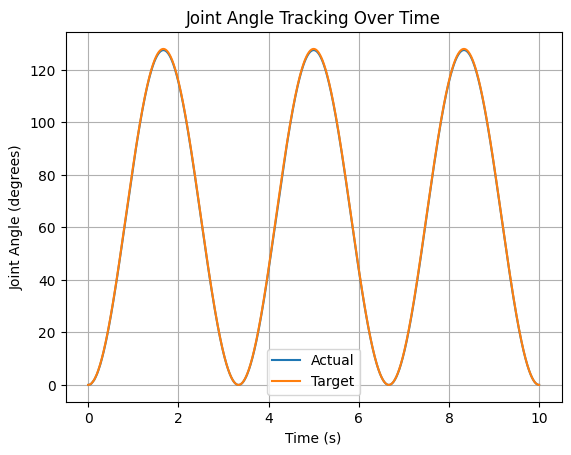

RMSE of joint angle tracking error: 0.3123 degrees


In [13]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import numpy as np
import torch
import mujoco
import mujoco.viewer
import time
import matplotlib.pyplot as plt
import scipy.sparse as spa
import osqp


# Load elbow model
_XML_ELBOW_Model = r"C:\Users\Nathaniel Kim\anaconda3\Lib\site-packages\myosuite\simhive\myo_sim\elbow\myoelbow_1dof6muscles.xml"
model = mujoco.MjModel.from_xml_path(_XML_ELBOW_Model)
data = mujoco.MjData(model)
temp_data = mujoco.MjData(model)  # reusable temp buffer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DEBUGflag = False

joint_idx = model.joint("r_elbow_flex").id
actuator_names = ['BIClong', 'BICshort', 'BRA', 'TRIlong', 'TRIlat', 'TRImed']
actuator_idxs = [model.actuator(name).id for name in actuator_names]
n_muscles = len(actuator_names)

duration = 10
fps = 1000
num_steps = int(duration * fps)
sim_dt = 1.0 / fps

# Target trajectory: cosine wave, 3 periods, 0 to 125 deg
amplitude = 128 / 2
offset = 125 / 2
periods = 3
x = np.linspace(0, 2 * np.pi * periods, num_steps)
angles_deg = amplitude * (1 - np.cos(x)) + 0

def solve_qp(P, q, lb, ub, x0):
    P = spa.csc_matrix(P)
    A = spa.eye(q.shape[0], format='csc')
    m = osqp.OSQP()
    m.setup(P=P, q=q, A=A, l=lb, u=ub, verbose=False)
    m.warm_start(x=x0)
    res = m.solve()
    return res.x

def get_qfrc(model, data, temp_data, target_qpos):
    temp_data.qpos[:] = data.qpos
    temp_data.qvel[:] = data.qvel
    temp_data.act[:] = data.act
    temp_data.qacc[:] = (((target_qpos - data.qpos) / model.opt.timestep) - data.qvel) / model.opt.timestep
    mujoco.mj_forward(model, temp_data)
    mujoco.mj_inverse(model, temp_data)
    return temp_data.qfrc_inverse.copy()

def get_muscle_ctrl(model, data, temp_data, target_qpos, qfrc):
    qvel_scaler = 1
    qfrc_scaler = 75
    act = data.act
    ctrl0 = data.ctrl
    ts = model.opt.timestep

    tA = model.actuator_dynprm[:, 0] * (0.5 + 1.5 * act)
    tD = model.actuator_dynprm[:, 1] / (0.5 + 1.5 * act)
    actuator_dynprm = torch.tensor(model.actuator_dynprm, dtype=torch.float32)

    tausmooth = 5
    model.actuator_dynprm[:, 2] = tausmooth
    t1 = (tA - tD) * 1.875 / tausmooth
    t2 = (tA + tD) * 0.5

    temp_data.qpos[:] = target_qpos
    temp_data.qvel[:] = ((target_qpos - data.qpos) / ts) / qvel_scaler
    temp_data.act[:] = data.act
    mujoco.mj_forward(model, temp_data)
    mujoco.mj_step1(model, temp_data)

    gain = np.zeros(model.nu)
    bias = np.zeros(model.nu)
    for i in range(model.nu):
        length = temp_data.actuator_length[i]
        lengthrange = model.actuator_lengthrange[i]
        velocity = temp_data.actuator_velocity[i]
        acc0 = model.actuator_acc0[i]
        prmb = model.actuator_biasprm[i, :9]
        prmg = model.actuator_gainprm[i, :9]
        bias[i] = mujoco.mju_muscleBias(length, lengthrange, acc0, prmb)
        gain[i] = min(-1, mujoco.mju_muscleGain(length, velocity, lengthrange, acc0, prmg))

    AM = temp_data.actuator_moment.T
    P = 2 * AM.T @ AM
    k = AM @ (gain * act) + AM @ bias - (qfrc / qfrc_scaler)
    q = 2 * k @ AM
    lb = gain * (1 - act) * ts / (t2 + t1 * (1 - act))
    ub = -gain * act * ts / (t2 - t1 * act)
    x0 = (gain * (ctrl0 - act) * ts) / ((ctrl0 - act) * t1 + t2)
    x = solve_qp(P, q, lb, ub, x0)
    ctrl = act + x * t2 / (gain * ts - x * t1)
    return np.clip(ctrl, 0, 1)

def run_simulation(model, data, temp_data, animate=True):
    actual_muscles = min(model.nu, n_muscles)
    history = {k: [] for k in ['q_current', 'q_target', 'error', 'velocity', 'torque_cmd', 'ctrl']}

    mujoco.mj_resetData(model, data)
    data.qpos[joint_idx] = np.radians(0)
    data.qvel[joint_idx] = 0.0
    mujoco.mj_forward(model, data)

    if animate:
        with mujoco.viewer.launch_passive(model=model, data=data) as viewer:
            mujoco.mjv_defaultFreeCamera(model, viewer.cam)
            viewer.cam.distance *= .05
            viewer.cam.elevation = -20
            viewer.cam.lookat[:] = [0, 0, 1.3]
            viewer.cam.azimuth -= 45
            viewer.cam.distance += 1

            try:
                for i in range(num_steps):
                    q_target = angles_deg[i]
                    target_qpos = data.qpos.copy()
                    target_qpos[joint_idx] = np.radians(q_target)

                    qfrc_needed = get_qfrc(model, data, temp_data, target_qpos)
                    ctrl = get_muscle_ctrl(model, data, temp_data, target_qpos, qfrc_needed)

                    if np.isnan(ctrl).any() or np.isinf(ctrl).any():
                        if DEBUGflag:
                            print(f"[ERROR] NaNs/Infs in ctrl at step {i}")
                        break

                    data.ctrl = ctrl
                    mujoco.mj_step(model, data)

                    q_current_val = np.degrees(data.qpos[joint_idx])
                    error_val = q_target - q_current_val
                    velocity_val = np.degrees(data.qvel[joint_idx])
                    torque_cmd_val = qfrc_needed[joint_idx]
                    ctrl_val = ctrl[:n_muscles]

                    history['q_current'].append(q_current_val)
                    history['q_target'].append(q_target)
                    history['error'].append(error_val)
                    history['velocity'].append(velocity_val)
                    history['torque_cmd'].append(torque_cmd_val)
                    history['ctrl'].append(ctrl_val)

                    if DEBUGflag:
                        print(f"{i:04d} | Target: {q_target:7.2f}°, Actual: {q_current_val:7.2f}°")
                    
                    viewer.sync()
                    time.sleep(1 / fps)
                    
            except Exception as e:
                print(f"Simulation failed: {e}")
    else:
        try:
            for i in range(num_steps):
                q_target = angles_deg[i]
                target_qpos = data.qpos.copy()
                target_qpos[joint_idx] = np.radians(q_target)

                qfrc_needed = get_qfrc(model, data, temp_data, target_qpos)
                ctrl = get_muscle_ctrl(model, data, temp_data, target_qpos, qfrc_needed)

                if np.isnan(ctrl).any() or np.isinf(ctrl).any():
                    if DEBUGflag:
                        print(f"[ERROR] NaNs/Infs in ctrl at step {i}")
                    break

                data.ctrl = ctrl
                mujoco.mj_step(model, data)

                q_current_val = np.degrees(data.qpos[joint_idx])
                error_val = q_target - q_current_val
                velocity_val = np.degrees(data.qvel[joint_idx])
                torque_cmd_val = qfrc_needed[joint_idx]
                ctrl_val = ctrl[:n_muscles]

                history['q_current'].append(q_current_val)
                history['q_target'].append(q_target)
                history['error'].append(error_val)
                history['velocity'].append(velocity_val)
                history['torque_cmd'].append(torque_cmd_val)
                history['ctrl'].append(ctrl_val)

                if DEBUGflag:
                    print(f"{i:04d} | Target: {q_target:7.2f}°, Actual: {q_current_val:7.2f}°")
        except Exception as e:
            print(f"Simulation failed: {e}")

    for key in history:
        history[key] = np.array(history[key], dtype=np.float32)

    return history

# === MAIN ===
history = run_simulation(model, data, temp_data, animate=True)

q_current_plot = history['q_current']
q_target_plot = history['q_target']
time_axis = np.arange(len(q_current_plot)) / fps

plt.plot(time_axis, q_current_plot, label='Actual')
plt.plot(time_axis, q_target_plot, label='Target')
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle (degrees)')
plt.title('Joint Angle Tracking Over Time')
plt.legend()
plt.grid(True)
plt.show()

errors = history['error']
if len(errors) > 0:
    rmse = np.sqrt(np.mean(errors**2))
    print(f"RMSE of joint angle tracking error: {rmse:.4f} degrees")
else:
    print("No data collected for RMSE calculation")


In [1]:
import pandas as pd
import numpy as np

# Load data
filepath = r"C:\Users\Nathaniel Kim\Desktop\R10.csv"
data = pd.read_csv(filepath)

# Filter time between 18.5 and 21 seconds
data = data[(data['time'] > 18.5)] #& (data['time'] < 21)]

# Convert angle column to NumPy array
angle_array = data['angle'].to_numpy()

# Compute duration
duration = float(data['time'].iloc[-1]) - float(data['time'].iloc[0])

# Output
print(angle_array)
print(duration)


[ 2.488552   2.5536675  2.6761203 ... 26.558268  26.548588  26.538906 ]
25.160531759


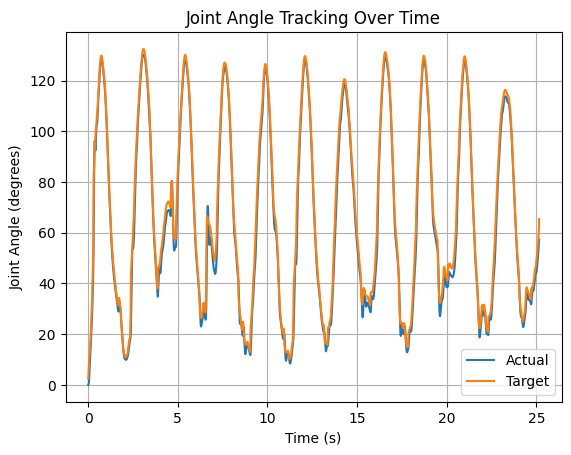

RMSE of joint angle tracking error: 3.9431 degrees


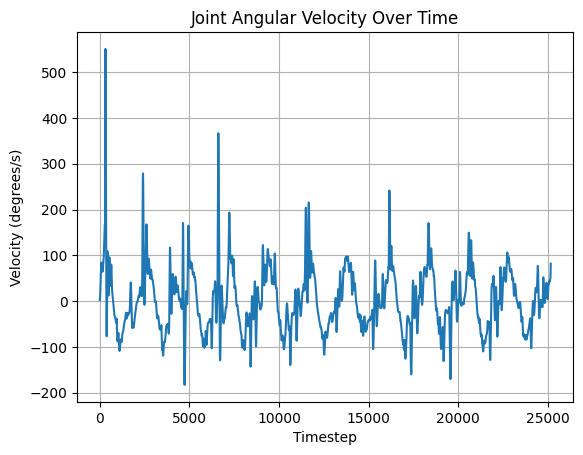

Velocity Std Dev: 68.5224 deg/s


In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import numpy as np
import torch
import mujoco
import mujoco.viewer
import time
import matplotlib.pyplot as plt
import scipy.sparse as spa
import osqp


# Load elbow model
_XML_ELBOW_Model = r"C:\Users\Nathaniel Kim\anaconda3\Lib\site-packages\myosuite\simhive\myo_sim\elbow\myoelbow_1dof6muscles.xml"
model = mujoco.MjModel.from_xml_path(_XML_ELBOW_Model)
data = mujoco.MjData(model)
temp_data = mujoco.MjData(model)  # reusable temp buffer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DEBUGflag = False

joint_idx = model.joint("r_elbow_flex").id
actuator_names = ['BIClong', 'BICshort', 'BRA', 'TRIlong', 'TRIlat', 'TRImed']
actuator_idxs = [model.actuator(name).id for name in actuator_names]
n_muscles = len(actuator_names)

#duration = 10
duration = duration
fps = 1000
num_steps = int(duration * fps)
sim_dt = 1.0 / fps

# # Sinusoidal sample Trajectory
# amplitude = 128 / 2
# offset = 125 / 2
# periods = 3
# x = np.linspace(0, 2 * np.pi * periods, num_steps)
# angles_deg = amplitude * (1 - np.cos(x)) + 0
angles_deg = angle_array

def solve_qp(P, q, lb, ub, x0):
    P = spa.csc_matrix(P)
    A = spa.eye(q.shape[0], format='csc')
    m = osqp.OSQP()
    m.setup(P=P, q=q, A=A, l=lb, u=ub, verbose=False)
    m.warm_start(x=x0)
    res = m.solve()
    return res.x

def get_qfrc(model, data, temp_data, target_qpos):
    temp_data.qpos[:] = data.qpos
    temp_data.qvel[:] = data.qvel
    temp_data.act[:] = data.act
    temp_data.qacc[:] = (((target_qpos - data.qpos) / model.opt.timestep) - data.qvel) / model.opt.timestep
    mujoco.mj_forward(model, temp_data)
    mujoco.mj_inverse(model, temp_data)
    return temp_data.qfrc_inverse.copy()

def get_muscle_ctrl(model, data, temp_data, target_qpos, qfrc):
    #####################
    qvel_scaler = 10
    qfrc_scaler = 200
    act = data.act
    ctrl0 = data.ctrl
    ts = model.opt.timestep

    tA = model.actuator_dynprm[:, 0] * (0.5 + 1.5 * act)
    tD = model.actuator_dynprm[:, 1] / (0.5 + 1.5 * act)

    actuator_dynprm = torch.tensor(model.actuator_dynprm, dtype=torch.float32)

    tausmooth = 5
    model.actuator_dynprm[:, 2] = tausmooth
    t1 = (tA - tD) * 1.875 / tausmooth
    t2 = (tA + tD) * 0.5

    temp_data.qpos[:] = target_qpos
    temp_data.qvel[:] = ((target_qpos - data.qpos) / ts) / qvel_scaler
    temp_data.act[:] = data.act
    mujoco.mj_forward(model, temp_data)
    mujoco.mj_step1(model, temp_data)

    gain = np.zeros(model.nu)
    bias = np.zeros(model.nu)
    
    for i in range(model.nu):
        length = temp_data.actuator_length[i]
        lengthrange = model.actuator_lengthrange[i]
        velocity = temp_data.actuator_velocity[i]
        acc0 = model.actuator_acc0[i]
        prmb = model.actuator_biasprm[i, :9]
        prmg = model.actuator_gainprm[i, :9]
        bias[i] = mujoco.mju_muscleBias(length, lengthrange, acc0, prmb)
        gain[i] = min(-1, mujoco.mju_muscleGain(length, velocity, lengthrange, acc0, prmg))

    AM = temp_data.actuator_moment.T
    P = 2 * AM.T @ AM #+ 1e-5 * np.eye(AM.shape[1])
    k = AM @ (gain * act) + AM @ bias - (qfrc / qfrc_scaler)
    q = 2 * k @ AM

    
    lb = gain * (1 - act) * ts / (t2 + t1 * (1 - act))
    ub = -gain * act * ts / (t2 - t1 * act)

    x0 = (gain * (ctrl0 - act) * ts) / ((ctrl0 - act) * t1 + t2)
    x = solve_qp(P, q, lb, ub, x0)
    ctrl = act + x * t2 / (gain * ts - x * t1)
    return np.clip(ctrl, 0, 1)

def run_simulation(model, data, temp_data, animate=True):
    actual_muscles = min(model.nu, n_muscles)
    history = {k: [] for k in ['q_current', 'q_target', 'error', 'velocity', 'torque_cmd', 'ctrl']}

    mujoco.mj_resetData(model, data)
    data.qpos[joint_idx] = np.radians(0)
    data.qvel[joint_idx] = 0.0
    mujoco.mj_forward(model, data)

    if animate:
        with mujoco.viewer.launch_passive(model=model, data=data) as viewer:
            mujoco.mjv_defaultFreeCamera(model, viewer.cam)
            viewer.cam.distance *= .05
            viewer.cam.elevation = -20
            viewer.cam.lookat[:] = [0, 0, 1.3]
            viewer.cam.azimuth -= 45
            viewer.cam.distance += 1

            try:
                for i in range(num_steps):
                    q_target = angles_deg[i]
                    target_qpos = data.qpos.copy()
                    target_qpos[joint_idx] = np.radians(q_target)

                    qfrc_needed = get_qfrc(model, data, temp_data, target_qpos)
                    ctrl = get_muscle_ctrl(model, data, temp_data, target_qpos, qfrc_needed)

                    if np.isnan(ctrl).any() or np.isinf(ctrl).any():
                        if DEBUGflag:
                            print(f"[ERROR] NaNs/Infs in ctrl at step {i}")
                        break

                    data.ctrl = ctrl
                    mujoco.mj_step(model, data)

                    q_current_val = np.degrees(data.qpos[joint_idx])
                    error_val = q_target - q_current_val
                    velocity_val = np.degrees(data.qvel[joint_idx])
                    torque_cmd_val = qfrc_needed[joint_idx]
                    ctrl_val = ctrl[:n_muscles]

                    history['q_current'].append(q_current_val)
                    history['q_target'].append(q_target)
                    history['error'].append(error_val)
                    history['velocity'].append(velocity_val)
                    history['torque_cmd'].append(torque_cmd_val)
                    history['ctrl'].append(ctrl_val)

                    if DEBUGflag:
                        print(f"{i:04d} | Target: {q_target:7.2f}°, Actual: {q_current_val:7.2f}°")
                    if i % 100 == 0:
                        viewer.sync()
                        time.sleep(1 / fps)
                    
            except Exception as e:
                print(f"Simulation failed: {e}")
    else:
        try:
            for i in range(num_steps):
                q_target = angles_deg[i]
                target_qpos = data.qpos.copy()
                target_qpos[joint_idx] = np.radians(q_target)

                qfrc_needed = get_qfrc(model, data, temp_data, target_qpos)
                ctrl = get_muscle_ctrl(model, data, temp_data, target_qpos, qfrc_needed)

                if np.isnan(ctrl).any() or np.isinf(ctrl).any():
                    if DEBUGflag:
                        print(f"[ERROR] NaNs/Infs in ctrl at step {i}")
                    break

                data.ctrl = ctrl
                mujoco.mj_step(model, data)

                q_current_val = np.degrees(data.qpos[joint_idx])
                error_val = q_target - q_current_val
                velocity_val = np.degrees(data.qvel[joint_idx])
                torque_cmd_val = qfrc_needed[joint_idx]
                ctrl_val = ctrl[:n_muscles]

                history['q_current'].append(q_current_val)
                history['q_target'].append(q_target)
                history['error'].append(error_val)
                history['velocity'].append(velocity_val)
                history['torque_cmd'].append(torque_cmd_val)
                history['ctrl'].append(ctrl_val)

                if DEBUGflag:
                    print(f"{i:04d} | Target: {q_target:7.2f}°, Actual: {q_current_val:7.2f}°")
        except Exception as e:
            print(f"Simulation failed: {e}")

    for key in history:
        history[key] = np.array(history[key], dtype=np.float32)

    return history

# === MAIN ===
history = run_simulation(model, data, temp_data, animate=True)

q_current_plot = history['q_current']
q_target_plot = history['q_target']
time_axis = np.arange(len(q_current_plot)) / fps

plt.plot(time_axis, q_current_plot, label='Actual')
plt.plot(time_axis, q_target_plot, label='Target')
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle (degrees)')
plt.title('Joint Angle Tracking Over Time')
plt.legend()
plt.grid(True)
plt.show()
errors = history['error']
if len(errors) > 0:
    rmse = np.sqrt(np.mean(errors**2))
    print(f"RMSE of joint angle tracking error: {rmse:.4f} degrees")
else:
    print("No data collected for RMSE calculation")


plt.plot(history['velocity'])
plt.title("Joint Angular Velocity Over Time")
plt.xlabel("Timestep")
plt.ylabel("Velocity (degrees/s)")
plt.grid(True)
plt.show()
vel_std = np.std(history['velocity'])
print(f"Velocity Std Dev: {vel_std:.4f} deg/s")


